<a href="https://colab.research.google.com/github/Koks-creator/MusicGeneresClassification/blob/main/RNNAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import files
from typing import Tuple
from zipfile import ZipFile
import os
import json
import math
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:12<00:00, 170MB/s]
100% 1.21G/1.21G [00:12<00:00, 107MB/s]


In [ ]:
FILE_NAME = "/content/gtzan-dataset-music-genre-classification.zip"
DATASET_PATH = "/content/Data/genres_original"
OUTPUT_PATH = "/content/data.json"
DURATION = 30  # length of music file in seconds
SAMPLE_RATE = 22050
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [ ]:
with ZipFile(FILE_NAME, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
def save_mfcc(dataset_path, json_path, samples_per_track: int, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(samples_per_track / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            for f in filenames:
                try:
                  file_path = os.path.join(dirpath, f)
                  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                  for d in range(num_segments):
                      start = samples_per_segment * d
                      finish = start + samples_per_segment
                      mfcc = librosa.feature.mfcc(y=signal[start:finish],
                                                  sr=sample_rate,
                                                  n_mfcc=num_mfcc,
                                                  n_fft=n_fft, hop_length=hop_length)
                      mfcc = mfcc.T

                      if len(mfcc) == num_mfcc_vectors_per_segment:
                          data["mfcc"].append(mfcc.tolist())
                          data["labels"].append(i-1)
                          print("{}, segment:{}".format(file_path, d+1))
                except Exception as e:
                  print(e)
                  print(f)

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, OUTPUT_PATH, SAMPLES_PER_TRACK, num_segments=10)


Processing: pop
/content/Data/genres_original/pop/pop.00035.wav, segment:1
/content/Data/genres_original/pop/pop.00035.wav, segment:2
/content/Data/genres_original/pop/pop.00035.wav, segment:3
/content/Data/genres_original/pop/pop.00035.wav, segment:4
/content/Data/genres_original/pop/pop.00035.wav, segment:5
/content/Data/genres_original/pop/pop.00035.wav, segment:6
/content/Data/genres_original/pop/pop.00035.wav, segment:7
/content/Data/genres_original/pop/pop.00035.wav, segment:8
/content/Data/genres_original/pop/pop.00035.wav, segment:9
/content/Data/genres_original/pop/pop.00035.wav, segment:10
/content/Data/genres_original/pop/pop.00001.wav, segment:1
/content/Data/genres_original/pop/pop.00001.wav, segment:2
/content/Data/genres_original/pop/pop.00001.wav, segment:3
/content/Data/genres_original/pop/pop.00001.wav, segment:4
/content/Data/genres_original/pop/pop.00001.wav, segment:5
/content/Data/genres_original/pop/pop.00001.wav, segment:6
/content/Data/genres_original/pop/pop.

<ipython-input-6-113c9d514eac>:31: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
/content/Data/genres_original/disco/disco.00018.wav, segment:6
/content/Data/genres_original/disco/disco.00018.wav, segment:7
/content/Data/genres_original/disco/disco.00018.wav, segment:8
/content/Data/genres_original/disco/disco.00018.wav, segment:9
/content/Data/genres_original/disco/disco.00018.wav, segment:10
/content/Data/genres_original/disco/disco.00086.wav, segment:1
/content/Data/genres_original/disco/disco.00086.wav, segment:2
/content/Data/genres_original/disco/disco.00086.wav, segment:3
/content/Data/genres_original/disco/disco.00086.wav, segment:4
/content/Data/genres_original/disco/disco.00086.wav, segment:5
/content/Data/genres_original/disco/disco.00086.wav, segment:6
/content/Data/genres_original/disco/disco.00086.wav, segment:7
/content/Data/genres_original/disco/disco.00086.wav, segment:8
/content/Data/genres_original/disco/disco.00086.wav, segment:9
/content/Data/genres_original/disco/disco.00086.wav,

In [ ]:
def load_data(dataset_path: str) -> Tuple[np.array, np.array]:
  with open(dataset_path) as f:
    data = json.load(f)


  X = np.array(data["mfcc"])
  y = np.array(data["labels"])
  mapping = data["mapping"]

  return X, y, mapping

In [ ]:
def prepare_dataset(test_size: float, validation_size: float, X: np.array, y: np.array) -> Tuple[np.array, np.array, np.array,
                                                                                          np.array, np.array, np.array]:

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=validation_size)

  return X_train, X_test, X_validation, y_train, y_test, y_validation

In [ ]:
X, y, mapping = load_data(OUTPUT_PATH)

X_train, X_test, X_validation, y_train, y_test, y_validation = prepare_dataset(test_size=.25, validation_size=.2, X=X, y=y)

In [ ]:
X_train.shape

(7489, 130, 13)

In [52]:
from tensorflow.keras import regularizers

model = keras.Sequential()

model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(128))

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(10, activation='softmax'))

In [53]:
optimiser = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
              )

In [54]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 130, 128)          72704     
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 239,882
Trainable params: 239,882
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    batch_size=32,
    epochs=25
)

Epoch 1/25
235/235 [==============================] - 109s 439ms/step - loss: 1.5375 - accuracy: 0.4475 - val_loss: 1.2698 - val_accuracy: 0.5080
Epoch 2/25
235/235 [==============================] - 98s 418ms/step - loss: 1.2116 - accuracy: 0.5650 - val_loss: 1.1395 - val_accuracy: 0.5560
Epoch 3/25
235/235 [==============================] - 98s 417ms/step - loss: 1.0767 - accuracy: 0.6192 - val_loss: 1.1844 - val_accuracy: 0.5780
Epoch 4/25
235/235 [==============================] - 100s 426ms/step - loss: 1.0440 - accuracy: 0.6359 - val_loss: 1.0407 - val_accuracy: 0.6180
Epoch 5/25
235/235 [==============================] - 99s 422ms/step - loss: 0.8721 - accuracy: 0.6976 - val_loss: 0.9449 - val_accuracy: 0.6500
Epoch 6/25
235/235 [==============================] - 97s 415ms/step - loss: 0.7994 - accuracy: 0.7240 - val_loss: 0.8893 - val_accuracy: 0.6900
Epoch 7/25
235/235 [==============================] - 99s 422ms/step - loss: 0.7211 - accuracy: 0.7512 - val_loss: 0.9148 - val_

In [56]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

63/63 - 8s - loss: 0.6880 - accuracy: 0.8107 - 8s/epoch - 124ms/step


In [57]:
def plot_history(history: keras.callbacks.History) -> None:
  fig, axis = plt.subplots(2)

  axis[0].plot(history.history["accuracy"], label="Train Accuracy")
  axis[0].plot(history.history["val_accuracy"], label="Test Accuracy")
  axis[0].set_ylabel("Accuracy")
  axis[0].legend(loc="lower right")
  axis[0].set_title("Accuracy eval")

  axis[1].plot(history.history["loss"], label="Train error")
  axis[1].plot(history.history["val_loss"], label="Test error")
  axis[1].set_xlabel("Epoch")
  axis[1].legend(loc="upper right")
  axis[1].set_title("Error eval")

  plt.show()

In [58]:
type(history)

keras.callbacks.History

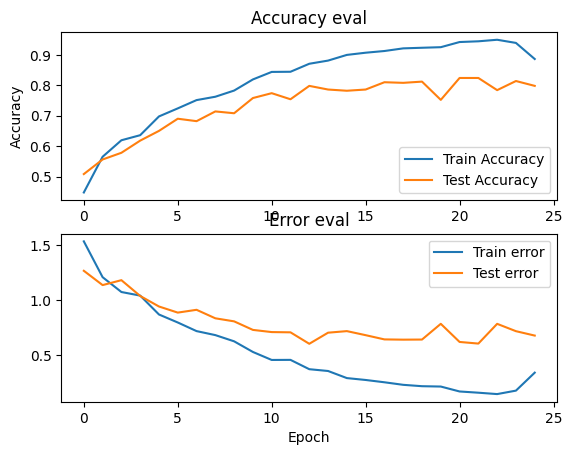

In [59]:
plot_history(history)

In [60]:
def test_model_prediction(model: keras.models.Sequential, X: np.array, expected_y: np.int64) -> bool:
  prediction = model.predict(np.array([X]))
  label = np.argmax(prediction)

  if expected_y == label:
    return True

  print(f"Expected label {expected_y}, predicted label: {label}")
  return False

In [61]:
for i in range(100):
  X = X_test[i]
  y = y_test[i]

  print(test_model_prediction(model, X, y))

1/1 [==============================] - 1s 1s/step
Expected label 8, predicted label: 7
False
1/1 [==============================] - 0s 35ms/step
True
1/1 [==============================] - 0s 46ms/step
Expected label 2, predicted label: 9
False
1/1 [==============================] - 0s 46ms/step
True
1/1 [==============================] - 0s 38ms/step
True
1/1 [==============================] - 0s 34ms/step
True
1/1 [==============================] - 0s 36ms/step
True
1/1 [==============================] - 0s 41ms/step
True
1/1 [==============================] - 0s 36ms/step
Expected label 8, predicted label: 5
False
1/1 [==============================] - 0s 37ms/step
True
1/1 [==============================] - 0s 38ms/step
Expected label 8, predicted label: 0
False
1/1 [==============================] - 0s 40ms/step
True
1/1 [==============================] - 0s 40ms/step
True
1/1 [==============================] - 0s 43ms/step
Expected label 1, predicted label: 4
False
1/1 [=========

In [62]:
mapping

['pop',
 'country',
 'blues',
 'reggae',
 'jazz',
 'disco',
 'classical',
 'metal',
 'rock',
 'hiphop']

In [47]:
model.save("RNN_Audio.h5")